In [2]:
library(Seurat)
library(SeuratDisk)
library(dplyr)
library(ggplot2)
library(patchwork)
library(stringr)
library(crayon)

The legacy packages maptools, rgdal, and rgeos, underpinning the sp package,
which was just loaded, will retire in October 2023.
Please refer to R-spatial evolution reports for details, especially
https://r-spatial.org/r/2023/05/15/evolution4.html.
It may be desirable to make the sf package available;
package maintainers should consider adding sf to Suggests:.
The sp package is now running under evolution status 2
     (status 2 uses the sf package in place of rgdal)

Attaching SeuratObject

Registered S3 method overwritten by 'SeuratDisk':
  method            from  
  as.sparse.H5Group Seurat


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘crayon’


The following object is masked from ‘package:ggplot2’:

    %+%




In [3]:
library(chromVAR)
library(JASPAR2020)
library(TFBSTools)
library(motifmatchr)
library(BSgenome.Hsapiens.UCSC.hg38)
library(Seurat)
library(Signac)
library(EnsDb.Hsapiens.v86)
library(dplyr)
library(ggplot2)



Loading required package: GenomeInfoDb

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors

Loading required package: stats4


Attaching package: ‘S4Vectors’


The following objects are masked from ‘package:dplyr’:

    first, rename


The following object is masked from ‘package:utils’:

    fi

In [4]:
# Parameters
data_path = "cellranger/outs"
h5_name = "CATATAC_5_CRISPR9.h5seurat"
prj_name = "CATATAC_CATATAC_5_CRISPR9"
protosp_path = "protospacers_.tsv"
mx_path   <- paste0(data_path, "/filtered_feature_bc_matrix/")

In [5]:
inputdata.10x <- Read10X(mx_path)

10X data contains more than one type and is being returned as a list containing matrices of each type.



In [6]:
# extract RNA and ATAC data
rna_counts  <- inputdata.10x$`Gene Expression`
atac_counts <- inputdata.10x$Peaks

In [7]:
seurat <- CreateSeuratObject(counts = rna_counts, project = prj_name)

In [8]:
n_init_cell_count = length(Cells(seurat))
n_init_cell_count

[1] 8008

In [9]:
seurat[["percent.mt"]] <- PercentageFeatureSet(seurat, pattern = "^MT-")

In [10]:
# Now add in the ATAC-seq data
# we'll only use peaks in standard chromosomes
grange.counts <- StringToGRanges(rownames(atac_counts), sep = c(":", "-"))
grange.use <- seqnames(grange.counts) %in% standardChromosomes(grange.counts)

In [11]:
atac_counts <- atac_counts[as.vector(grange.use), ]
annotations <- GetGRangesFromEnsDb(ensdb = EnsDb.Hsapiens.v86)

Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warn

In [12]:
seqlevelsStyle(annotations) <- 'UCSC'
genome(annotations)         <- "hg38"

In [13]:
frag.file <- paste0(data_path, "/atac_fragments.tsv.gz")
chrom_assay <- CreateChromatinAssay(
   counts = atac_counts,
   sep = c(":", "-"),
   genome = 'hg38',
   fragments = frag.file,
   annotation = annotations
 )
seurat[["ATAC"]] <- chrom_assay

Computing hash



In [14]:
# add the gene information to the object
DefaultAssay(seurat) <- "ATAC"
Annotation(seurat) <- annotations
DefaultAssay(seurat) <- "RNA"

In [15]:
DefaultAssay(seurat) <- "ATAC"
seurat <- NucleosomeSignal(seurat)
seurat <- TSSEnrichment(seurat)

Extracting TSS positions

Extracting fragments at TSSs


Computing TSS enrichment score



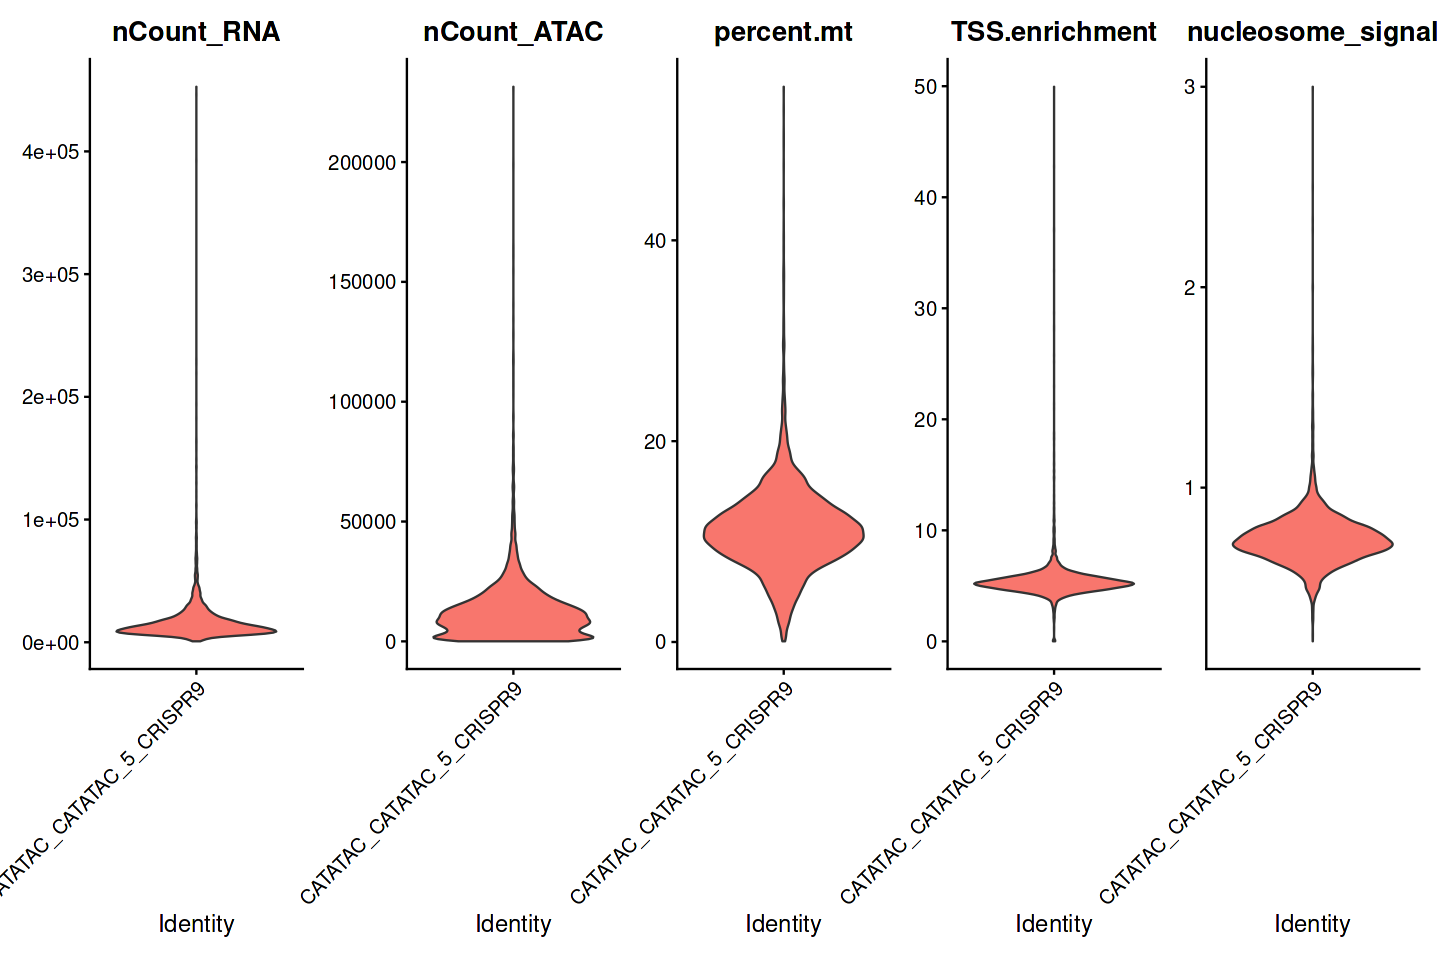

In [16]:
options(repr.plot.width=12, repr.plot.height=8)

VlnPlot(
  object = seurat,
  features = c("nCount_RNA", "nCount_ATAC", "percent.mt", "TSS.enrichment", "nucleosome_signal"),
  ncol = 5,
  pt.size = 0
)

In [17]:
seurat <- subset(
  x = seurat,
  subset = nCount_ATAC < 6e4 &
    nCount_ATAC > 3000 &
    nCount_RNA < 40000 &
    nCount_RNA > 1000 &
    percent.mt < 20 &
    nucleosome_signal < 2 &
    TSS.enrichment > 1
)

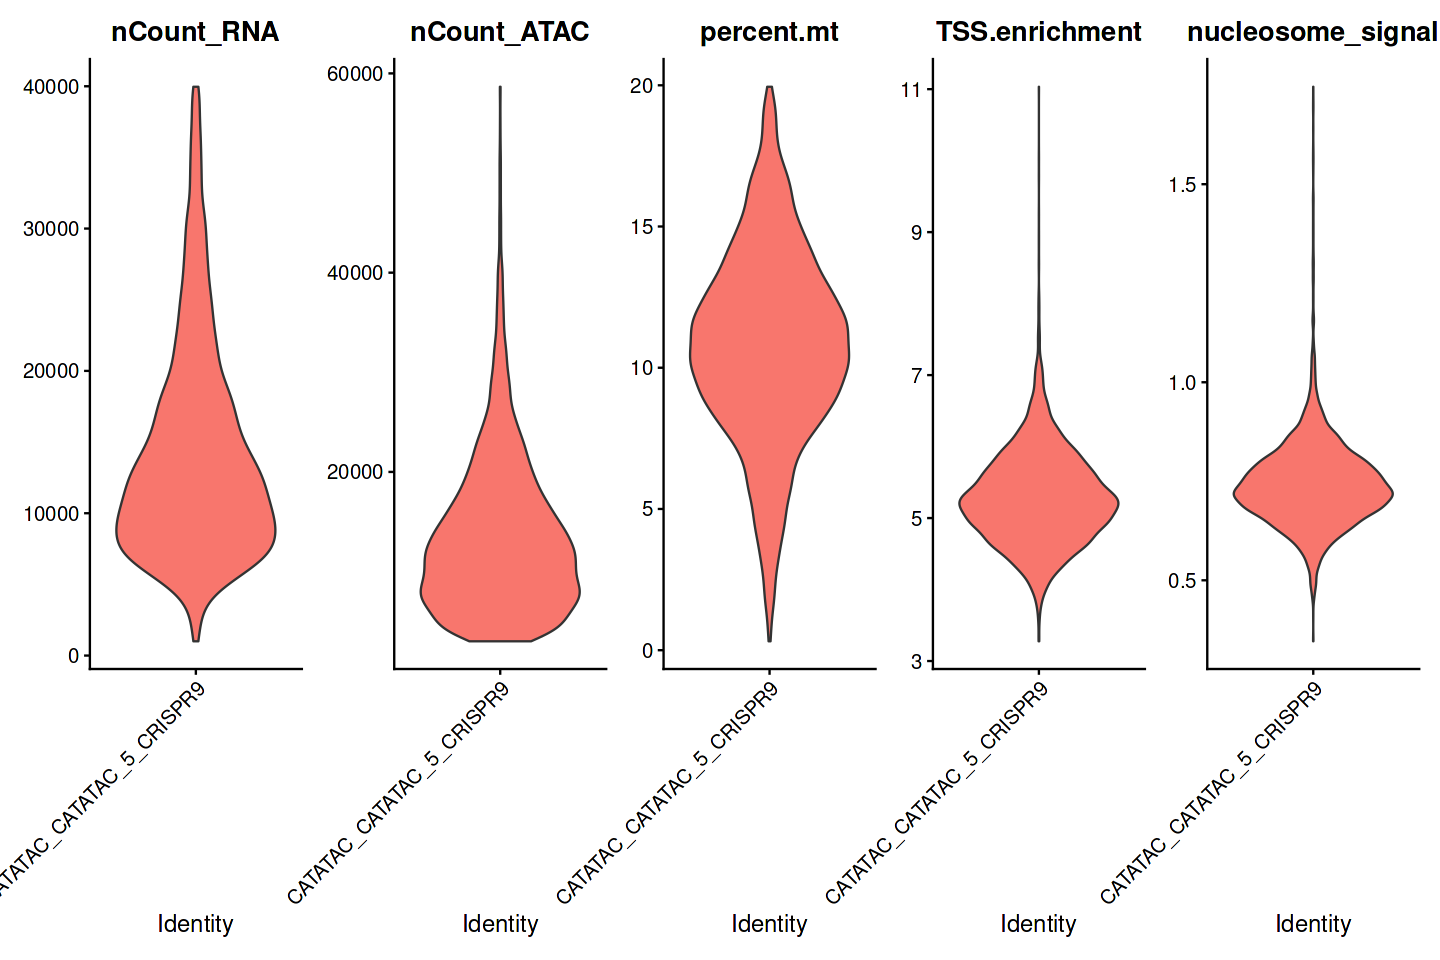

In [18]:
VlnPlot(
  object = seurat,
  features = c("nCount_RNA", "nCount_ATAC", "percent.mt", "TSS.enrichment", "nucleosome_signal"),
  ncol = 5,
  pt.size = 0
)

In [19]:
length(Cells(seurat))

[1] 6058

# SVD

In [20]:
# RNA analysis
DefaultAssay(seurat) <- "RNA"
seurat <- SCTransform(seurat, verbose = FALSE) %>% RunPCA() %>% RunUMAP(dims = 1:10, reduction.name = 'umap.rna', reduction.key = 'rnaUMAP_')

# ATAC analysis
# We exclude the first dimension as this is typically correlated with sequencing depth
DefaultAssay(seurat) <- "ATAC"
seurat <- RunTFIDF(seurat)
seurat <- FindTopFeatures(seurat, min.cutoff = 'q0')
seurat <- RunSVD(seurat)
seurat <- RunUMAP(seurat, reduction = 'lsi', dims = 2:10, reduction.name = "umap.atac", reduction.key = "atacUMAP_")

PC_ 1 
Positive:  PTPRZ1, L1TD1, PTN, GRID2, RPLP1, HSP90AB1, RPL41, HMGB1, SFRP2, SFRP1 
	   RPS8, HSP90AA1, POLR3G, BCAT1, POU5F1, TMEM132B, RPS2, NASP, NES, PTMA 
	   FGFBP3, NPM1, RPS6, RPS15, RPL13, VIM, RPS3, CDH6, RPS23, RPS18 
Negative:  FN1, HAS2, SLIT3, PCDH7, TFPI, RCN3, AC068587.4, BAMBI, MEIS2, LHX1 
	   CTNNA2, LRP1B, ZFPM2, NKX2-5, LAPTM4B, FOXP2, BMP4, DGKB, IFI16, ROBO2 
	   MECOM, NRP1, KIF26B, KRT18, GRIK2, FAM184A, HAPLN1, S100A11, GATA5, PCAT14 
PC_ 2 
Positive:  DCC, EBF2, STMN2, IGFBPL1, TUBB3, DLL3, MAP2, ADARB2, MALAT1, KCNIP4 
	   ELAVL3, SRRM4, NAV2, SYT1, EBF1, DCX, ST18, CADPS, NOVA1, CACNA2D1 
	   NEUROG2, EFNA5, ADGRL3, MAP1B, NCAM1, EBF3, NRXN1, RUNX1T1, KALRN, CTNND2 
Negative:  FN1, KRT18, HAS2, TPM1, RCN3, BAMBI, NKX2-5, PTMA, SLIT3, LAPTM4B 
	   HSP90AB1, FST, BMP4, HMGB1, S100A11, KRT8, PCAT14, APOE, ID3, MYL7 
	   RPL41, ID1, MT-ND1, PCDH7, HSP90AA1, RPLP1, L1TD1, ACTB, MT-ND2, MT-ND4 
PC_ 3 
Positive:  L1TD1, GRID2, PCAT14, PCDH11X, AC022140.1, PO

In [21]:
seurat <- FindMultiModalNeighbors(seurat, reduction.list = list("pca", "lsi"), dims.list = list(1:10, 2:10))
seurat <- RunUMAP(seurat, nn.name = "weighted.nn", reduction.name = "wnn.umap", reduction.key = "wnnUMAP_")
seurat <- FindClusters(seurat, graph.name = "wsnn", algorithm = 3, resolution = 0.15, verbose = FALSE)

Calculating cell-specific modality weights

Finding 20 nearest neighbors for each modality.

Calculating kernel bandwidths

Finding multimodal neighbors

Constructing multimodal KNN graph

Constructing multimodal SNN graph

15:38:52 UMAP embedding parameters a = 0.9922 b = 1.112

15:38:53 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 20

15:38:56 Initializing from normalized Laplacian + noise (using irlba)

15:38:56 Commencing optimization for 500 epochs, with 178460 positive edges

15:39:04 Optimization finished



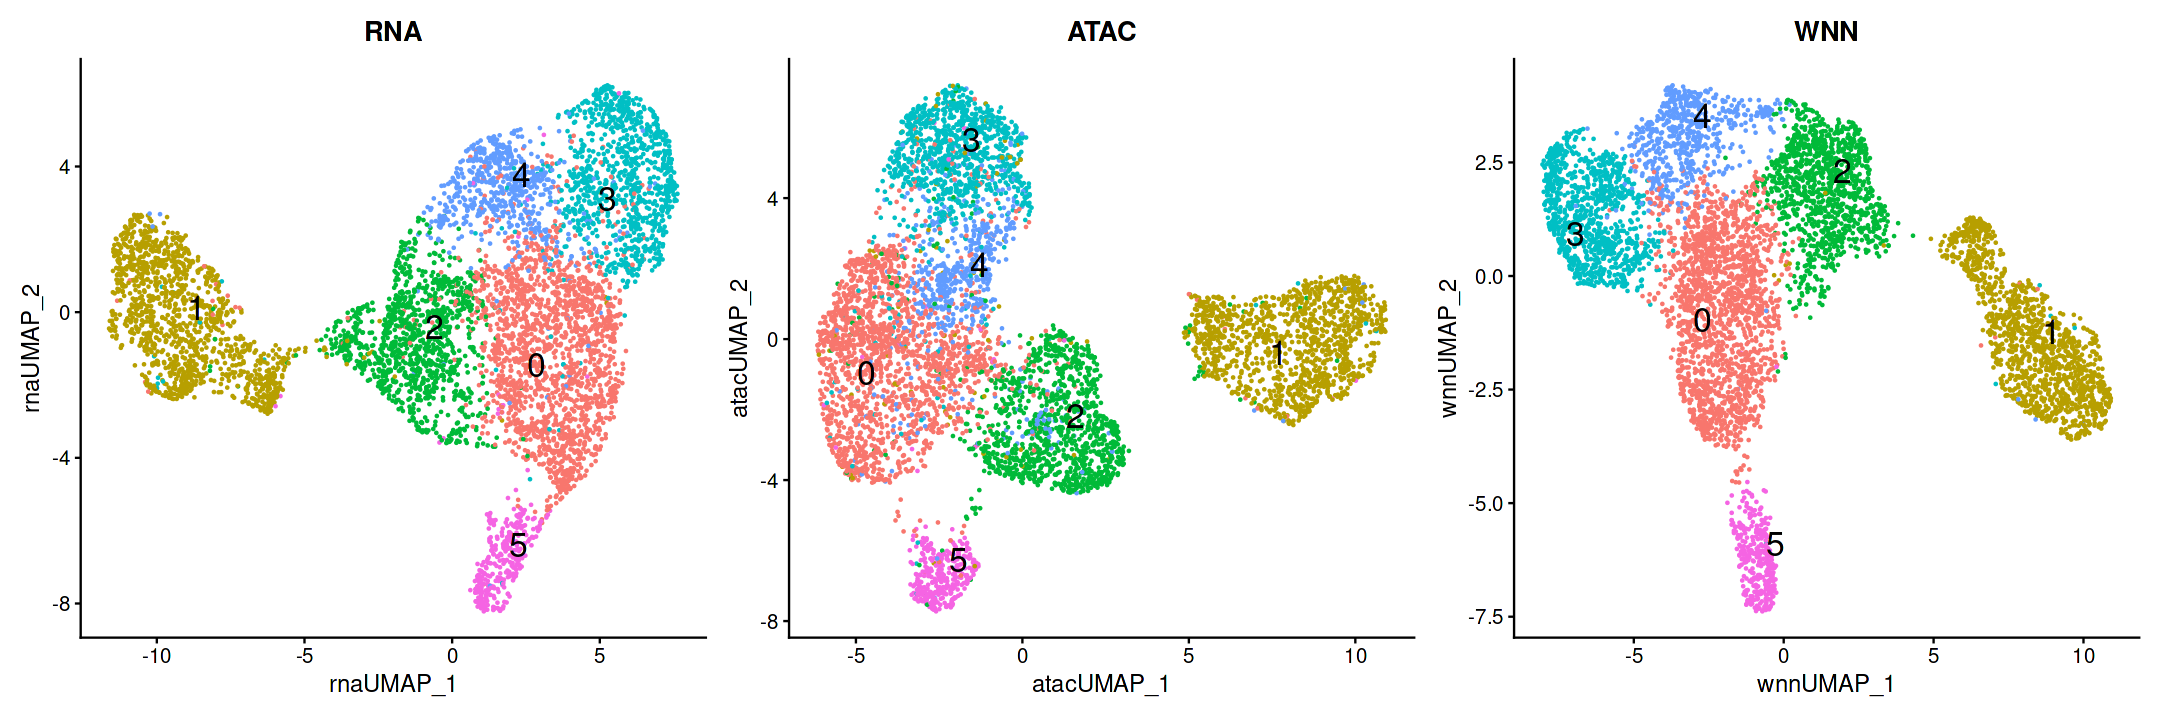

In [22]:
p1 <- DimPlot(seurat, reduction = "umap.rna", label = TRUE, label.size = 7, repel = TRUE) + ggtitle("RNA")
p2 <- DimPlot(seurat, reduction = "umap.atac", label = TRUE, label.size = 7, repel = TRUE) + ggtitle("ATAC")
p3 <- DimPlot(seurat, reduction = "wnn.umap", label = TRUE, label.size = 7, repel = TRUE) + ggtitle("WNN")
options(repr.plot.width=18, repr.plot.height=6)
p1 + p2 + p3 & NoLegend() & theme(plot.title = element_text(hjust = 0.5))

In [23]:
#Get cluster counts
cluster_counts <- table(Idents(seurat))
as.data.frame(cluster_counts)

Var1 Freq
1 0    1764
2 1    1269
3 2    1105
4 3     980
5 4     604
6 5     336

Renamed clusters

In [24]:
seurat <- RenameIdents(object = seurat, "0" = "Intermediate", "1" = "GATA5", "2" = "iPSC",
                           "3" = "MEOX1", "4" = "MEOX1", "5" = "NEUROG2")

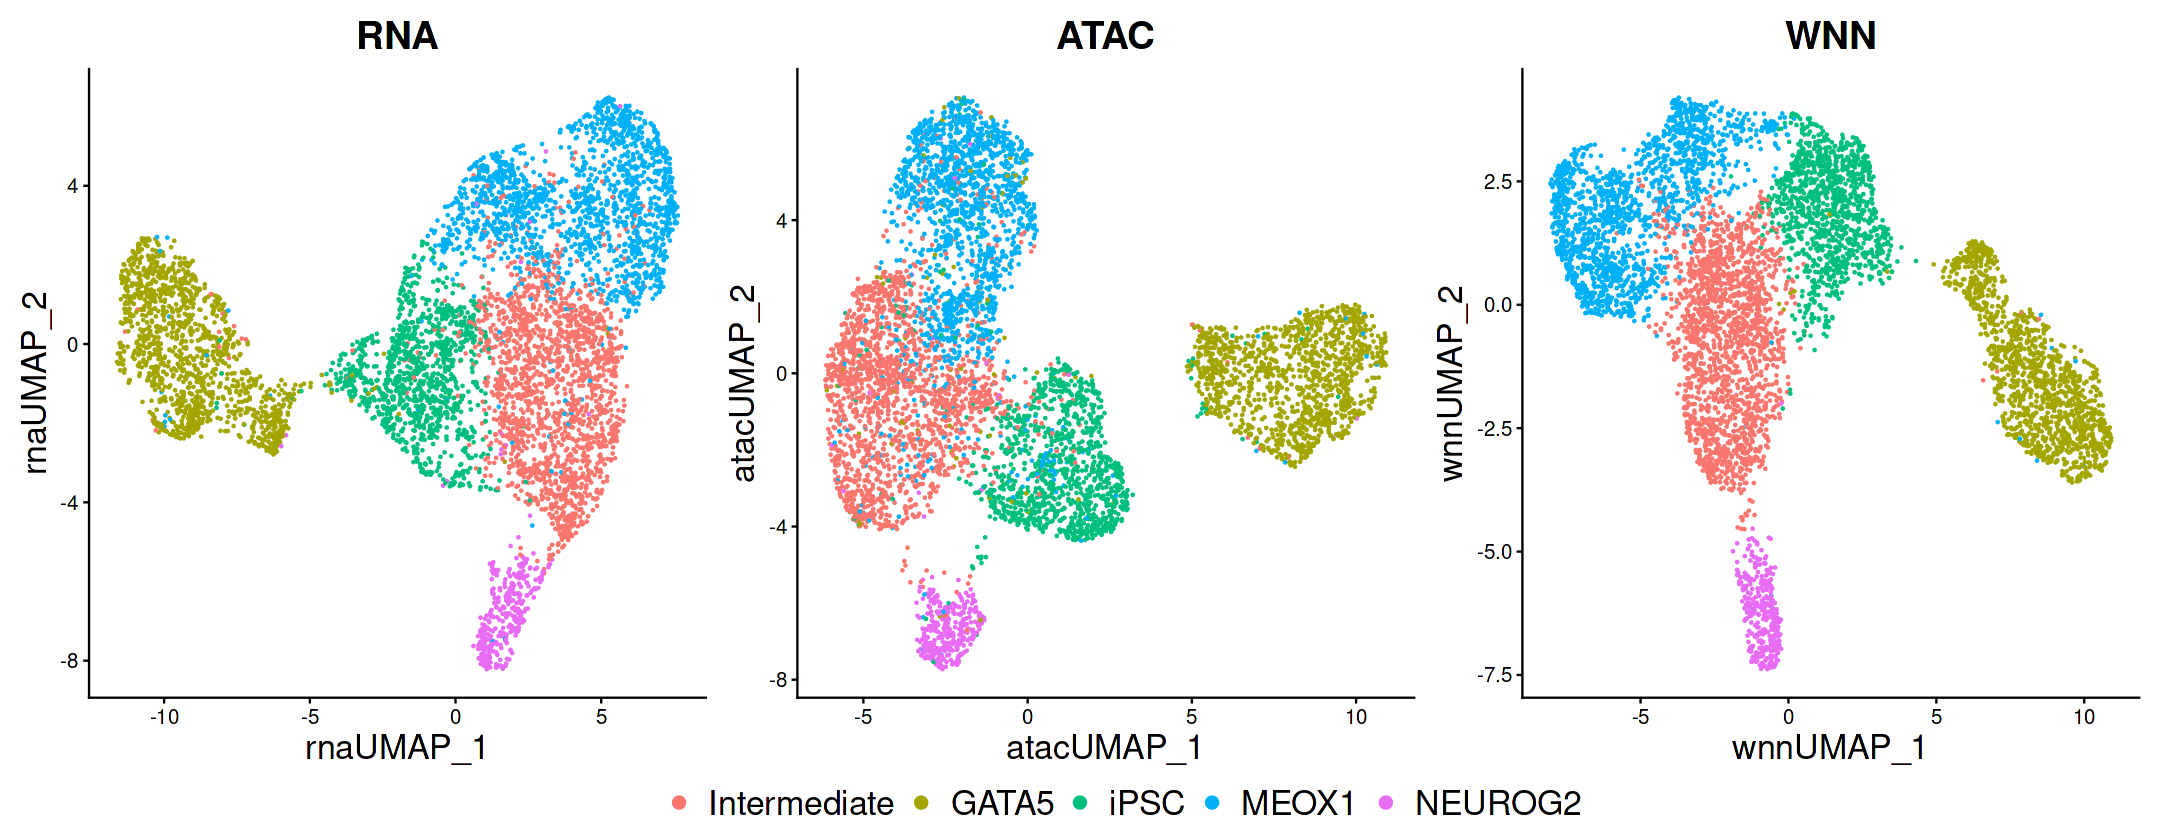

In [25]:
p1 <- DimPlot(seurat, reduction = "umap.rna", label.size = 7, repel = TRUE) + NoLegend() + ggtitle("RNA")
p2 <- DimPlot(seurat, reduction = "umap.atac", label.size = 7, repel = TRUE) + NoLegend() + ggtitle("ATAC")
p3 <- DimPlot(seurat, reduction = "wnn.umap", label.size = 7, repel = TRUE) + ggtitle("WNN")
options(repr.plot.width=18, repr.plot.height=7)

combined <- p1 + p2 + p3 & theme(legend.position = "bottom", text = element_text(size = 20), plot.title = element_text(hjust = 0.5),
                                legend.text = element_text(size=20))
combined + plot_layout(guides = "collect")

In [26]:
DefaultAssay(seurat) <- "SCT"
tf.list <- c("NEUROG2", "GATA5", "MEOX1", "NANOG")
tf.list2 <- c("FAM89A", "CDK15", "RP11-398G24.2", "FBXW4", "LYZL1", "DAB1", "LINC00976", "RP11-587H10.2", "FAM84B", "TMEM14B")
options(repr.plot.width=10, repr.plot.height=8)

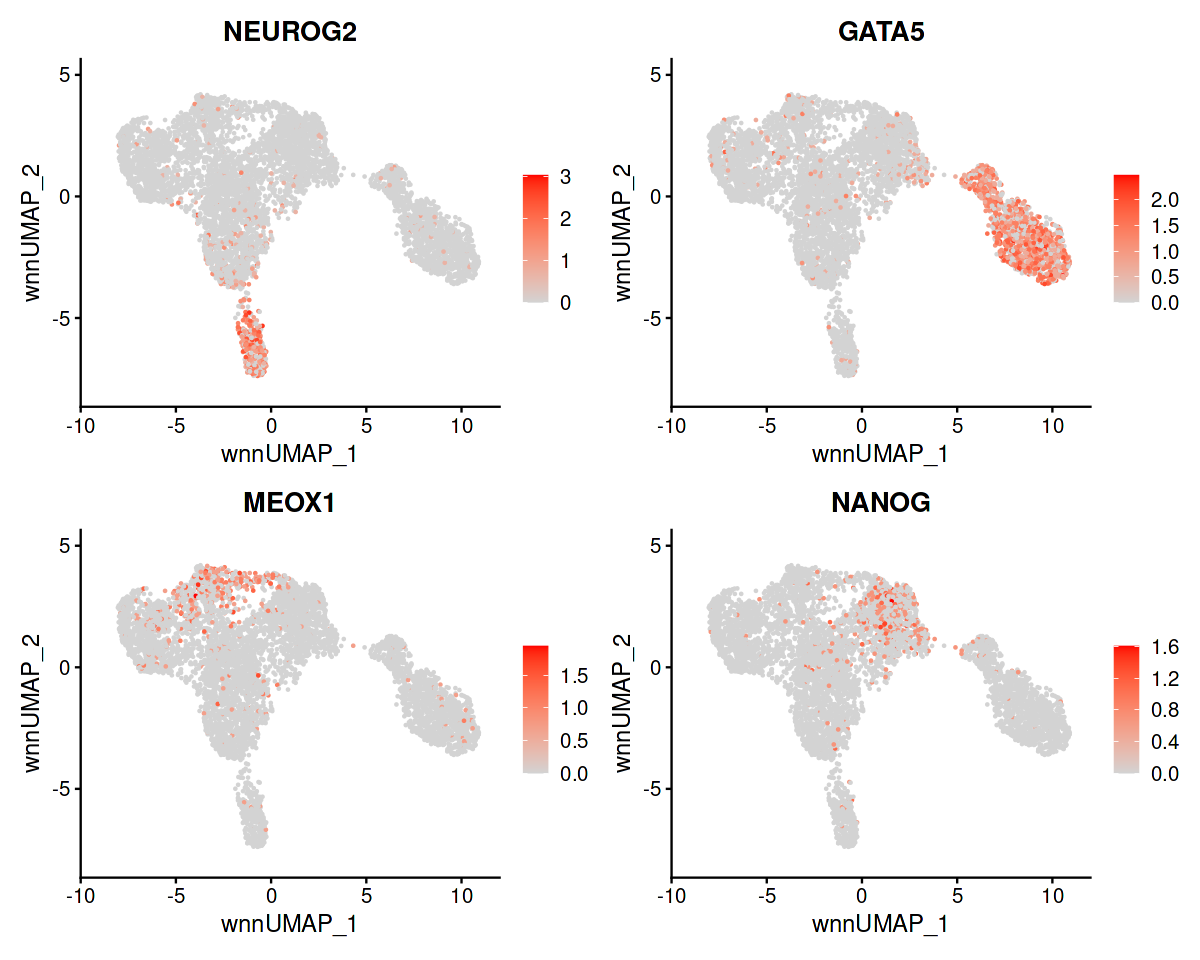

In [27]:
gene_plot <- FeaturePlot(seurat, features = tf.list, reduction = 'wnn.umap', cols = c("lightgrey", "red"))
gene_plot

Warning message in FetchData.Seurat(object = object, vars = c(dims, "ident", features), :
"The following requested variables were not found: RP11-398G24.2, LINC00976, RP11-587H10.2, FAM84B"


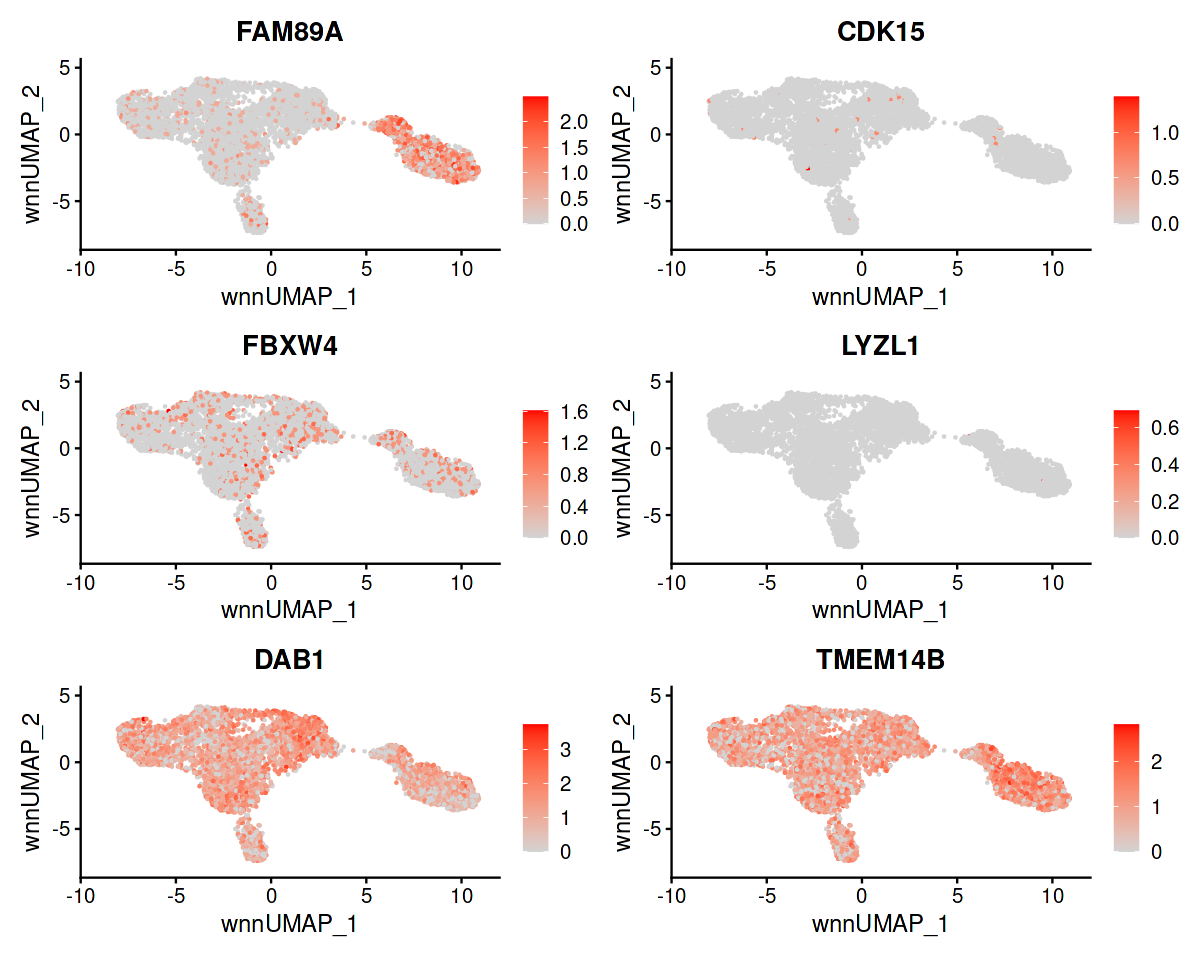

In [28]:
gene_plot2 <- FeaturePlot(seurat, features = tf.list2, reduction = 'wnn.umap', cols = c("lightgrey", "red"))
gene_plot2

# Motif analysis, Figure 1 I

In [29]:
DefaultAssay(seurat) <- "ATAC"
pwm_set <- getMatrixSet(x = JASPAR2020, opts = list(species = 9606, all_versions = FALSE))
motif.matrix <- CreateMotifMatrix(features = granges(seurat), pwm = pwm_set, genome = 'hg38', use.counts = FALSE)
motif.object <- CreateMotifObject(data = motif.matrix, pwm = pwm_set)
seurat <- SetAssayData(seurat, assay = 'ATAC', slot = 'motifs', new.data = motif.object)

In [30]:
seurat <- RunChromVAR(
  object = seurat,
  genome = BSgenome.Hsapiens.UCSC.hg38
)

Computing GC bias per region

Selecting background regions

Computing deviations from background

Constructing chromVAR assay



Warning message:
"Could not find MA0766.2 in the default search locations, found in chromvar assay instead"


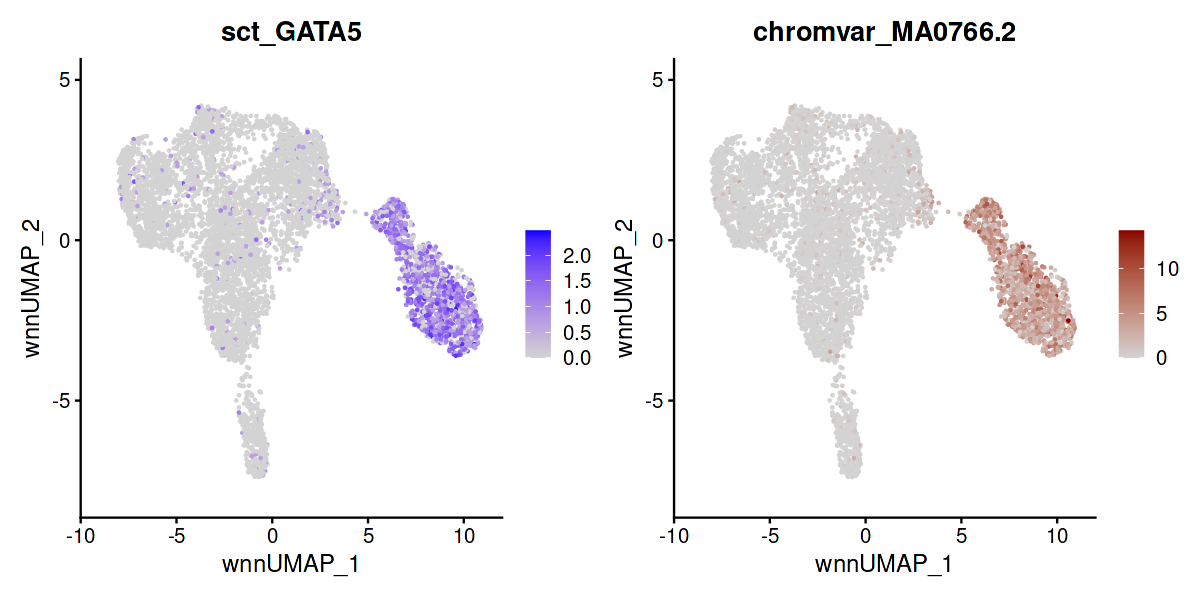

In [31]:
options(repr.plot.width=10, repr.plot.height=5)
motif.name <- ConvertMotifID(seurat, name = 'GATA5')
gene_plot <- FeaturePlot(seurat, features = "sct_GATA5", reduction = 'wnn.umap')
motif_plot <- FeaturePlot(seurat, features = motif.name, min.cutoff = 0, cols = c("lightgrey", "darkred"), reduction = 'wnn.umap')
gene_plot | motif_plot

Warning message:
"Could not find MA0669.1 in the default search locations, found in chromvar assay instead"


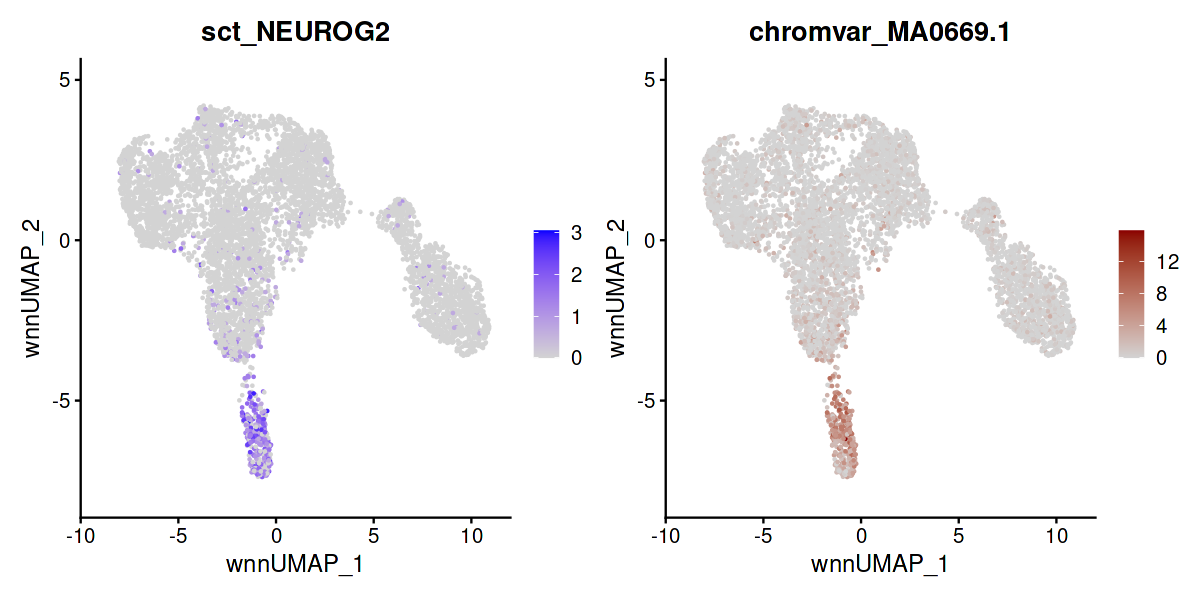

In [32]:
motif.name <- ConvertMotifID(seurat, name = 'NEUROG2')
gene_plot <- FeaturePlot(seurat, features = "sct_NEUROG2", reduction = 'wnn.umap')
motif_plot <- FeaturePlot(seurat, features = motif.name, min.cutoff = 0, cols = c("lightgrey", "darkred"), reduction = 'wnn.umap')
gene_plot | motif_plot

Warning message:
"Could not find MA0661.1 in the default search locations, found in chromvar assay instead"


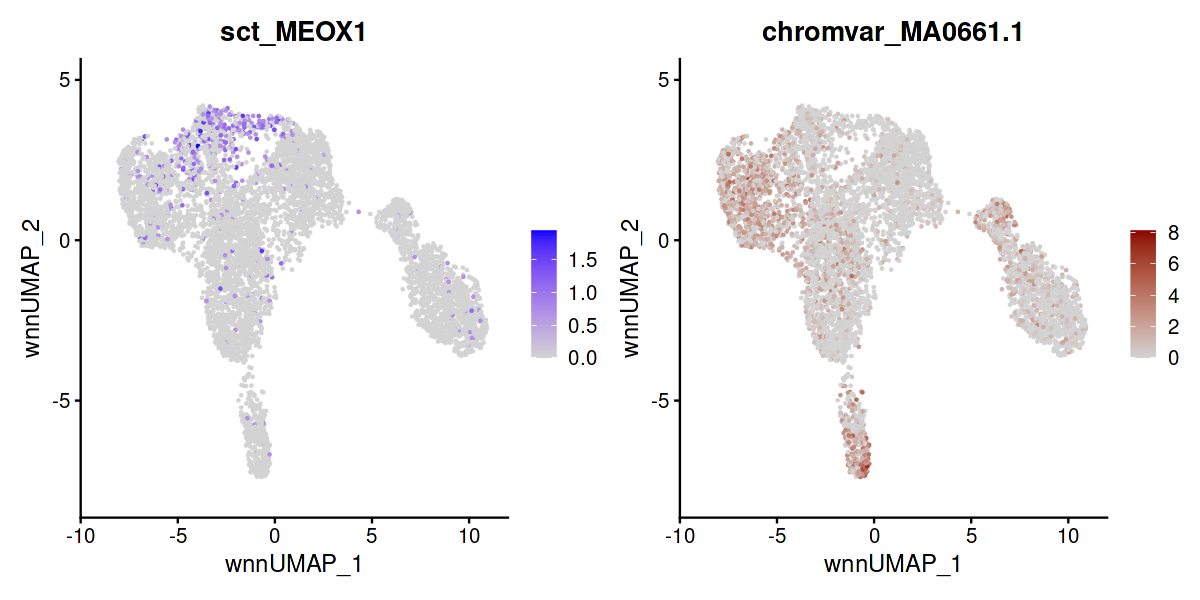

In [33]:
motif.name <- ConvertMotifID(seurat, name = 'MEOX1')
gene_plot <- FeaturePlot(seurat, features = "sct_MEOX1", reduction = 'wnn.umap')
motif_plot <- FeaturePlot(seurat, features = motif.name, min.cutoff = 0, cols = c("lightgrey", "darkred"), reduction = 'wnn.umap')
gene_plot | motif_plot

Warning message:
"Could not find MA1115.1 in the default search locations, found in chromvar assay instead"


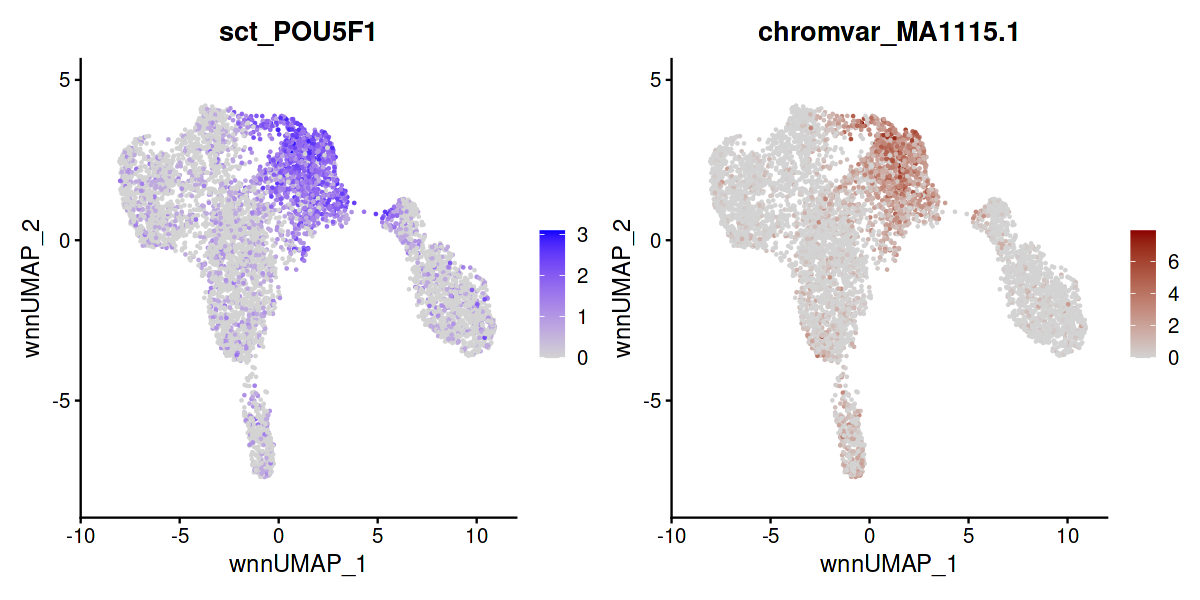

In [34]:
motif.name <- ConvertMotifID(seurat, name = 'POU5F1')
gene_plot <- FeaturePlot(seurat, features = "sct_POU5F1", reduction = 'wnn.umap')
motif_plot <- FeaturePlot(seurat, features = motif.name, min.cutoff = 0, cols = c("lightgrey", "darkred"), reduction = 'wnn.umap')
gene_plot | motif_plot

Warning message:
"Could not find MA0143.4 in the default search locations, found in chromvar assay instead"


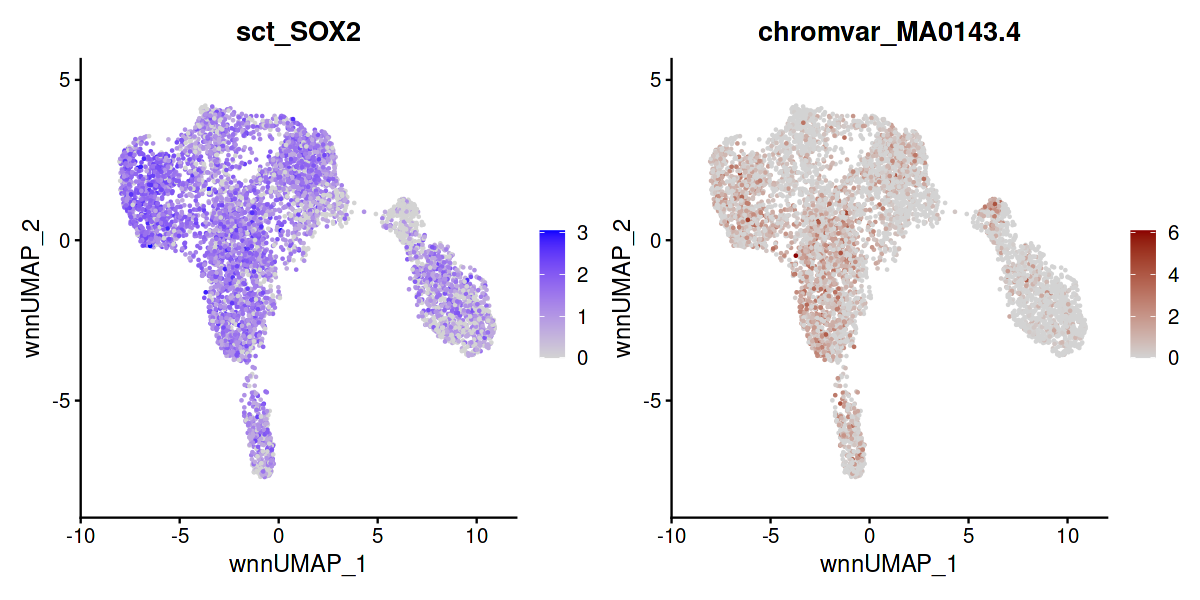

In [35]:
motif.name <- ConvertMotifID(seurat, name = 'SOX2')
gene_plot <- FeaturePlot(seurat, features = "sct_SOX2", reduction = 'wnn.umap')
motif_plot <- FeaturePlot(seurat, features = motif.name, min.cutoff = 0, cols = c("lightgrey", "darkred"), reduction = 'wnn.umap')
gene_plot | motif_plot

In [36]:
library(motifmatchr)
library(JASPAR2020)
library(TFBSTools)


In [37]:
# add motif information
seurat <- AddMotifs(object = seurat, genome = BSgenome.Hsapiens.UCSC.hg38, pfm = pwm_set)

Building motif matrix

Finding motif positions

Creating Motif object



In [38]:
#DefaultAssay(seurat) <- "ATAC"
# gather the footprinting information for sets of motifs
seurat <- Footprint(
  object = seurat,
  motif.name = c("GATA5", "NEUROG2", "MEOX1", "POU5F1"),
  genome = BSgenome.Hsapiens.UCSC.hg38
)



Computing Tn5 insertion bias

Extracting reads in requested region

Computing observed Tn5 insertions per base

Computing base composition at motif sites

Computing expected Tn5 insertions per base

Finding + strand cut sites

Finding - strand cut sites

Computing observed Tn5 insertions per base

Computing base composition at motif sites

Computing expected Tn5 insertions per base

Finding + strand cut sites

Finding - strand cut sites

Computing observed Tn5 insertions per base

Computing base composition at motif sites

Computing expected Tn5 insertions per base

Finding + strand cut sites

Finding - strand cut sites

Computing observed Tn5 insertions per base

Computing base composition at motif sites

Computing expected Tn5 insertions per base

Finding + strand cut sites

Finding - strand cut sites



In [39]:
# plot the footprint data for each group of cells
footprint <- PlotFootprint(seurat, features = c("GATA5", "MEOX1", "NEUROG2", "POU5F1"), label.top = 1)

# Figure 1J

Warning message:
"Removed 2550 rows containing missing values (`geom_label_repel()`)."
Warning message:
"Removed 2550 rows containing missing values (`geom_label_repel()`)."
Warning message:
"Removed 2550 rows containing missing values (`geom_label_repel()`)."
Warning message:
"Removed 2555 rows containing missing values (`geom_label_repel()`)."


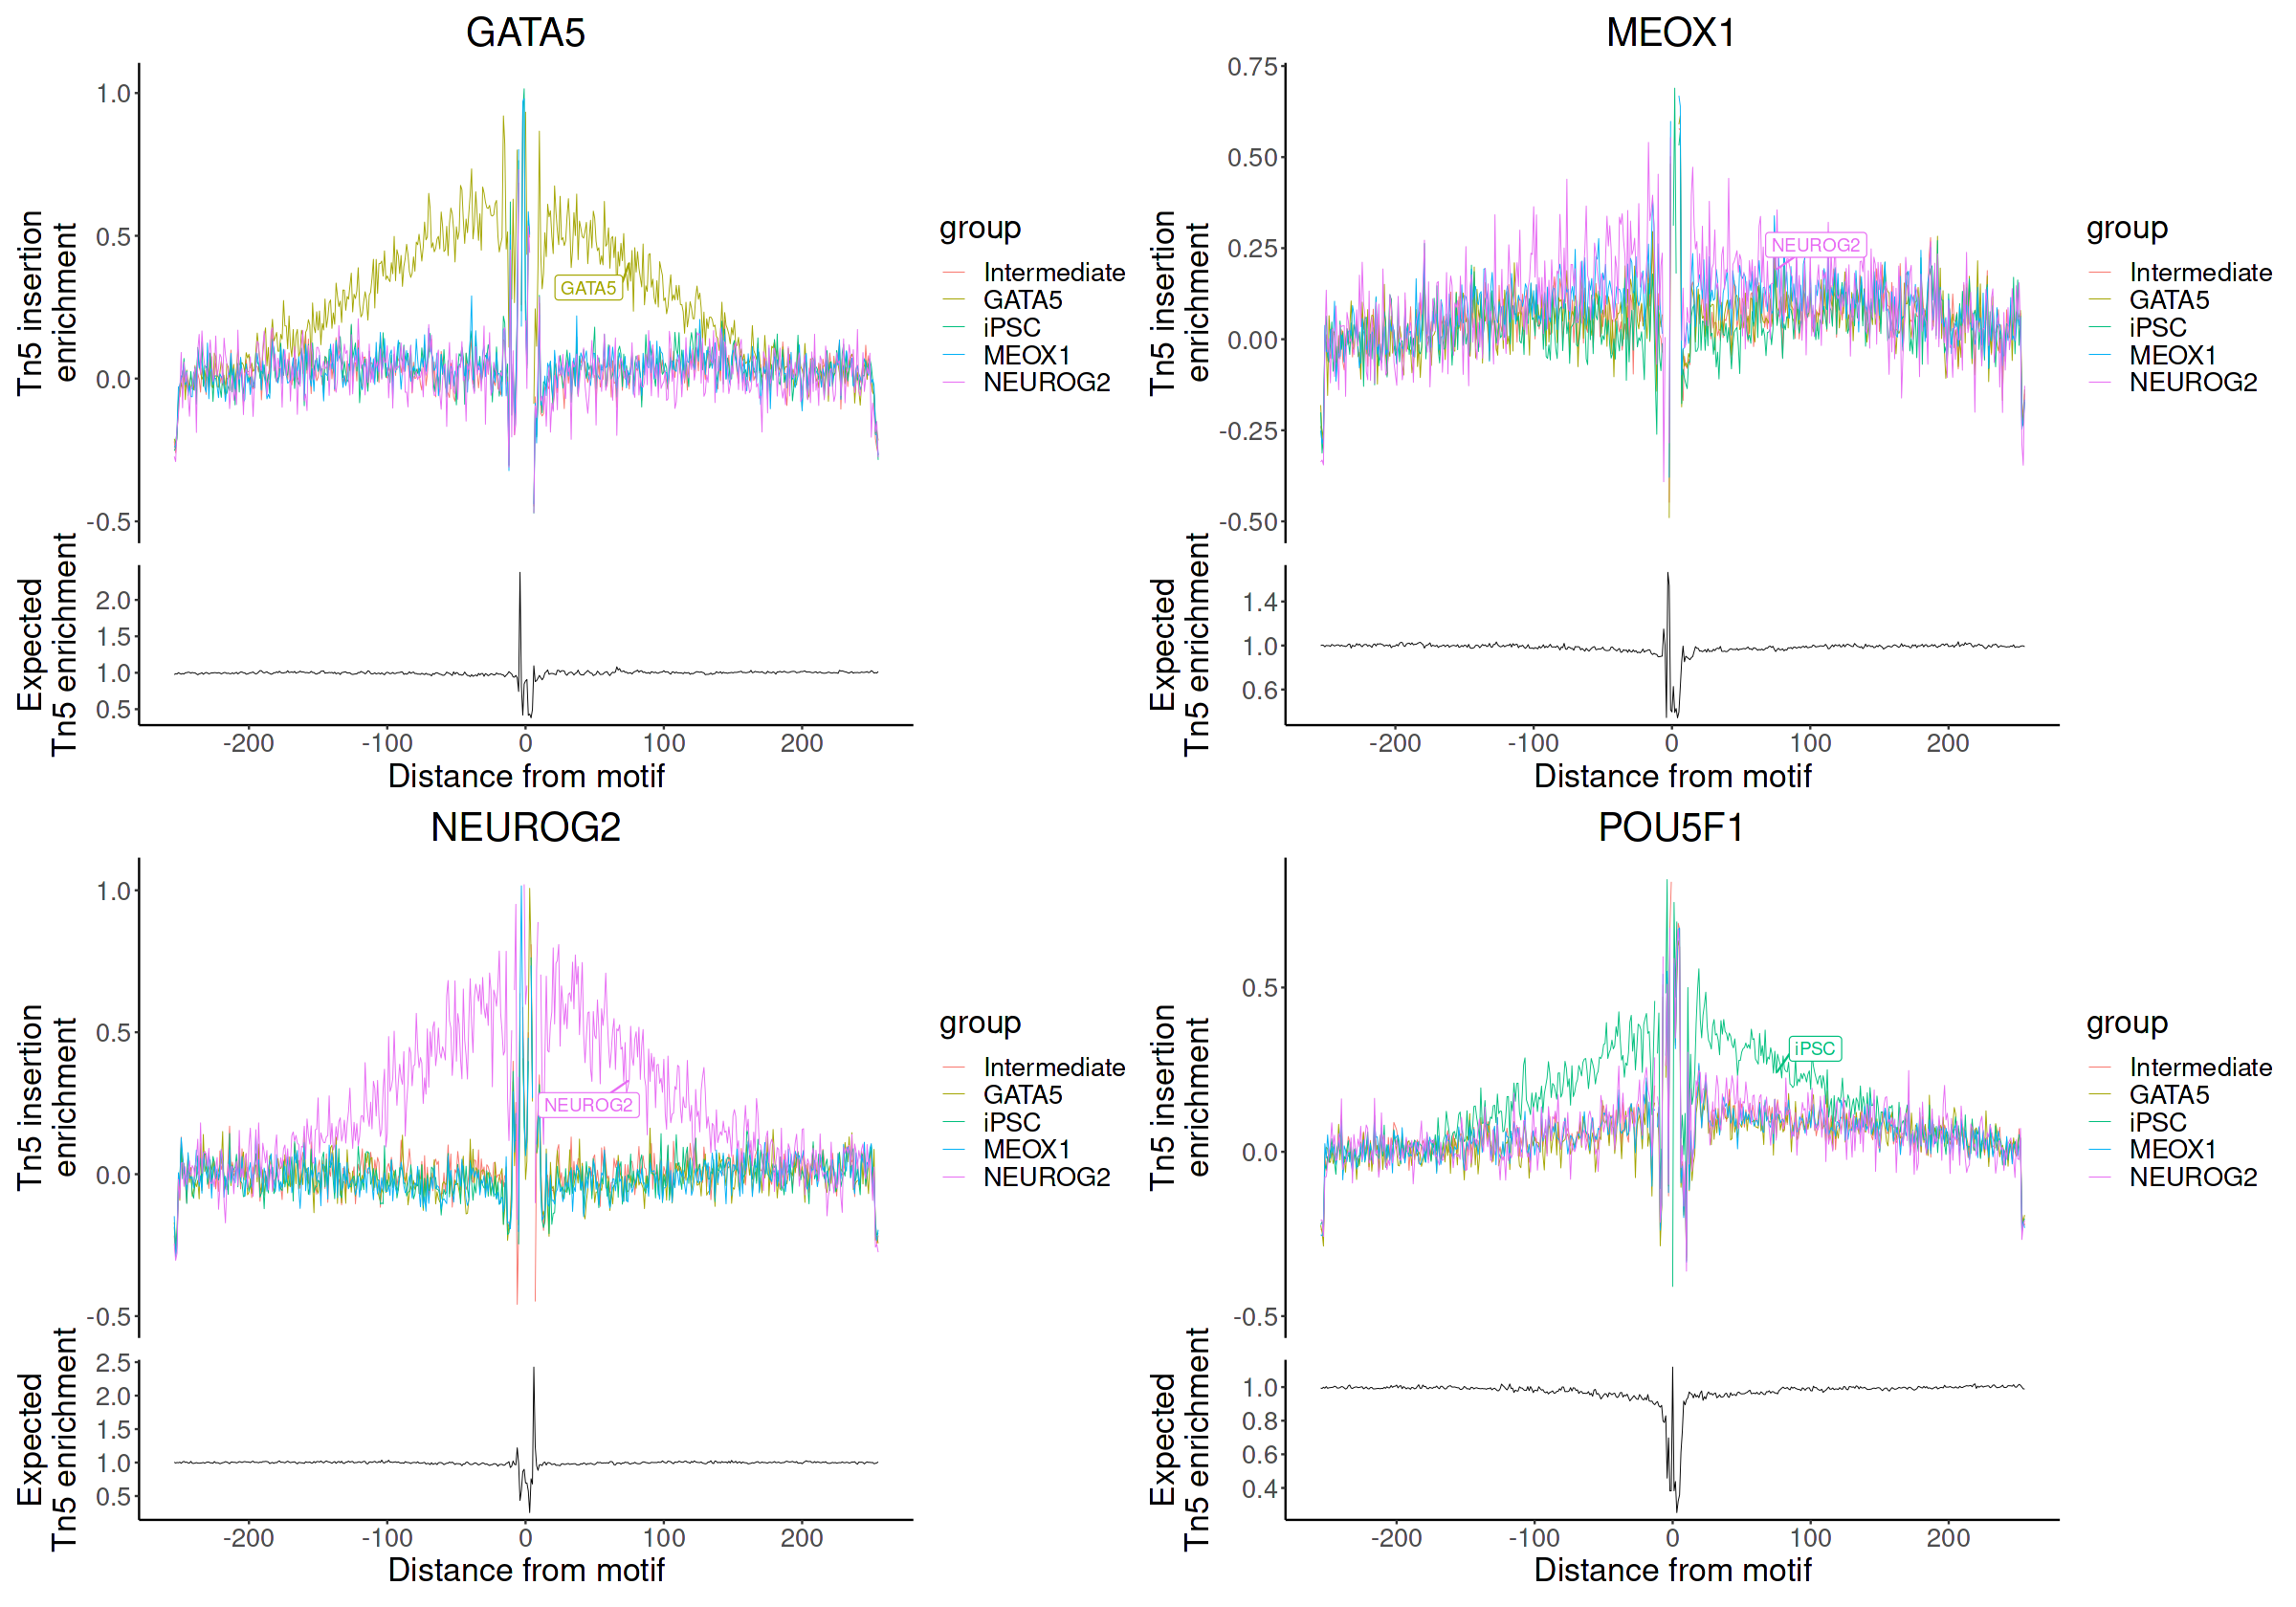

In [40]:
options(repr.plot.width=20, repr.plot.height=14)
footprint & theme(text = element_text(size = 20), plot.title = element_text(hjust = 0.5))

# Linking peaks to genes

In [41]:
# call peaks using MACS2
peaks <- CallPeaks(seurat, assay = "ATAC", macs2.path = "/home/vsevim/software/anaconda3/envs/Renv/bin/macs2")

In [42]:
# remove peaks on nonstandard chromosomes and in genomic blacklist regions
peaks <- keepStandardChromosomes(peaks, pruning.mode = "coarse")
peaks <- subsetByOverlaps(x = peaks, ranges = blacklist_hg38_unified, invert = TRUE)

In [43]:
# quantify counts in each peak
macs2_counts <- FeatureMatrix(
  fragments = Fragments(seurat),
  features = peaks,
  cells = colnames(seurat)
)

Extracting reads overlapping genomic regions



In [ ]:
# create a new assay using the MACS2 peak set and add it to the Seurat object
seurat[["peaks"]] <- CreateChromatinAssay(
  counts = macs2_counts,
  fragments = frag.file,
  annotation = annotations
)


In [ ]:
DefaultAssay(seurat) <- "peaks"

# first compute the GC content for each peak
seurat <- RegionStats(seurat, genome = BSgenome.Hsapiens.UCSC.hg38)

# link peaks to genes
seurat <- LinkPeaks(
  object = seurat,
  peak.assay = "peaks",
  expression.assay = "SCT",
  genes.use = c("NEUROG2", "GATA5", "MEOX1", "POU5F1", "STMN2", "EMX2", "FN1", "FAM78B", "KCNIP4", "NES", "NHLH1", "HAND2",
               "GATA3")
)

In [ ]:
options(repr.plot.width=15, repr.plot.height=10)
p1 <- CoveragePlot(
  object = seurat,
  region = "NEUROG2",
  features = "NEUROG2",
  expression.assay = "SCT",
  extend.upstream = 5000,
  extend.downstream = 5000
)
#patchwork::wrap_plots(p1, ncol = 1)
options(repr.plot.width=7, repr.plot.height=7)
p1 & theme(text = element_text(size = 10))


In [ ]:
options(repr.plot.width=15, repr.plot.height=10)
p1 <- CoveragePlot(
  object = seurat,
  region = "NHLH1",
  features = c("NHLH1", "NEUROG2"),
  expression.assay = "SCT",
  extend.upstream = 50000,
  extend.downstream = 50000
)

# # Increase font size using the theme() function
# p1 <- p1 + theme(
#   text = element_text(size = 16),  # Adjust the font size as needed
#   axis.title = element_text(size = 16),
#   axis.text = element_text(size = 14),  # Adjust axis text size
#   axis.text.x = element_text(angle = 45, hjust = 1)  # Rotate x-axis tick labels
# )

#patchwork::wrap_plots(p1, ncol = 1)
options(repr.plot.width=10, repr.plot.height=7)
p1 & theme(text = element_text(size = 14))

Warning message:
"Removed 5 rows containing missing values (`geom_segment()`)."


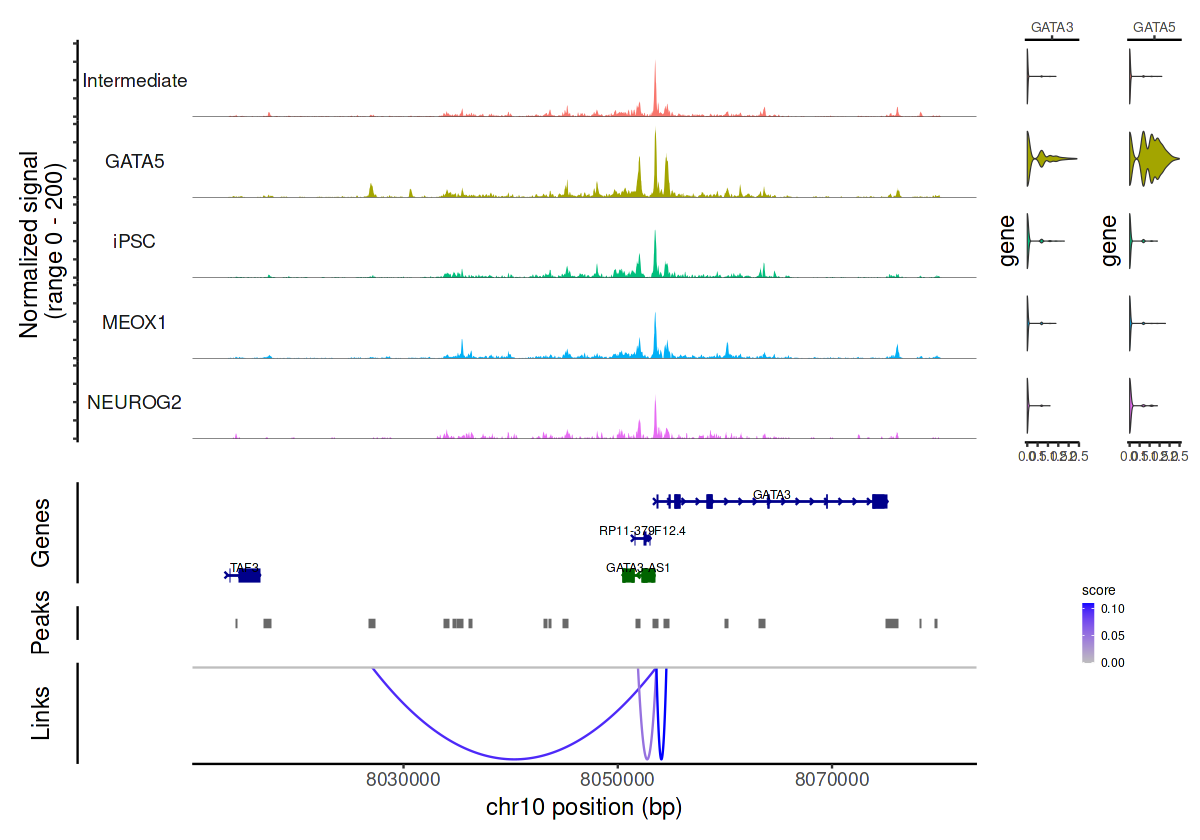

In [47]:
options(repr.plot.width=15, repr.plot.height=10)
p1 <- CoveragePlot(
  object = seurat,
  region = "GATA3",
  features = c("GATA3", "GATA5"),
  expression.assay = "SCT",
  extend.upstream = 40000,
  extend.downstream = 5000
)
#patchwork::wrap_plots(p1, ncol = 1)
options(repr.plot.width=10, repr.plot.height=7)
p1 & theme(text = element_text(size = 14))

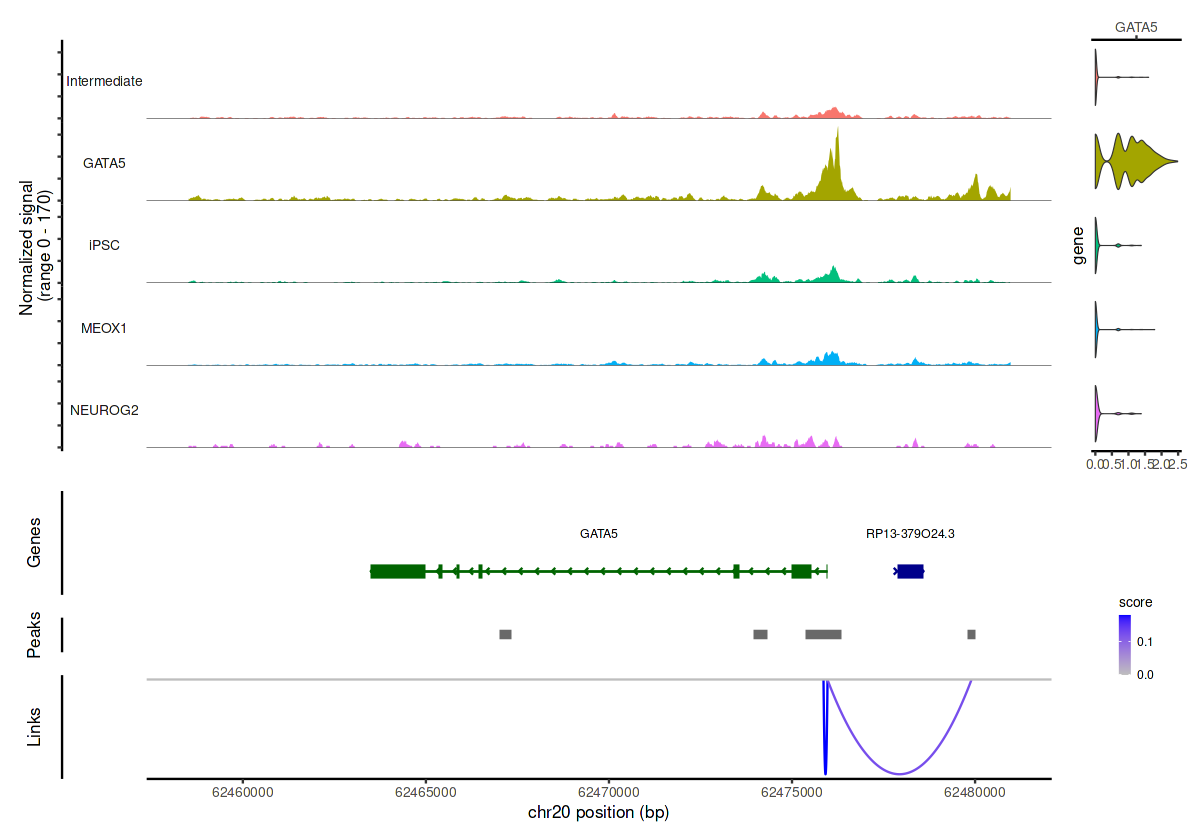

In [48]:
p2 <- CoveragePlot(
  object = seurat,
  region = "GATA5",
  features = "GATA5",
  expression.assay = "SCT",
  extend.upstream = 5000,
  extend.downstream = 5000
)
#patchwork::wrap_plots(p2, ncol = 1)
p2 & theme(text = element_text(size = 10))

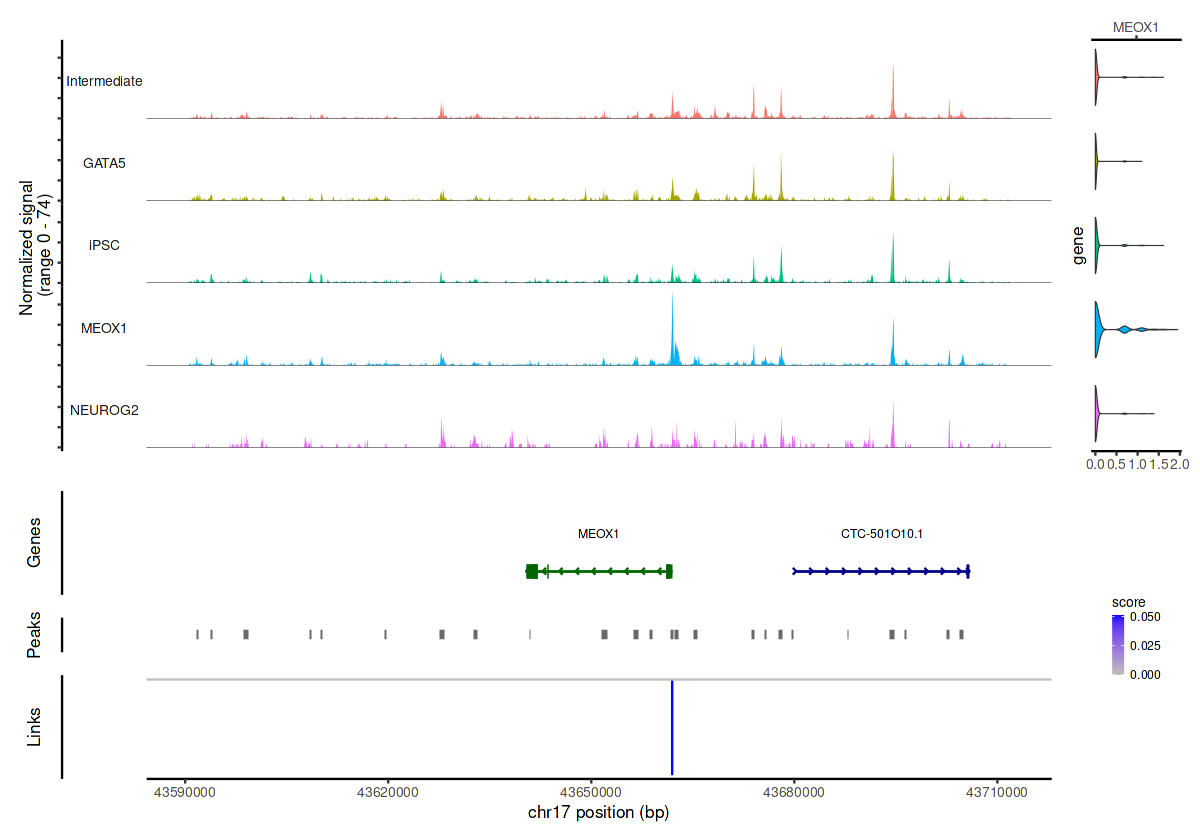

In [49]:
p3 <- CoveragePlot(
  object = seurat,
  region = "MEOX1",
  features = "MEOX1",
  expression.assay = "SCT",
  extend.upstream = 50000,
  extend.downstream = 50000
)
#patchwork::wrap_plots(p3, ncol = 1)
p3 & theme(text = element_text(size = 10))

Warning message:
"Removed 4 rows containing missing values (`geom_segment()`)."


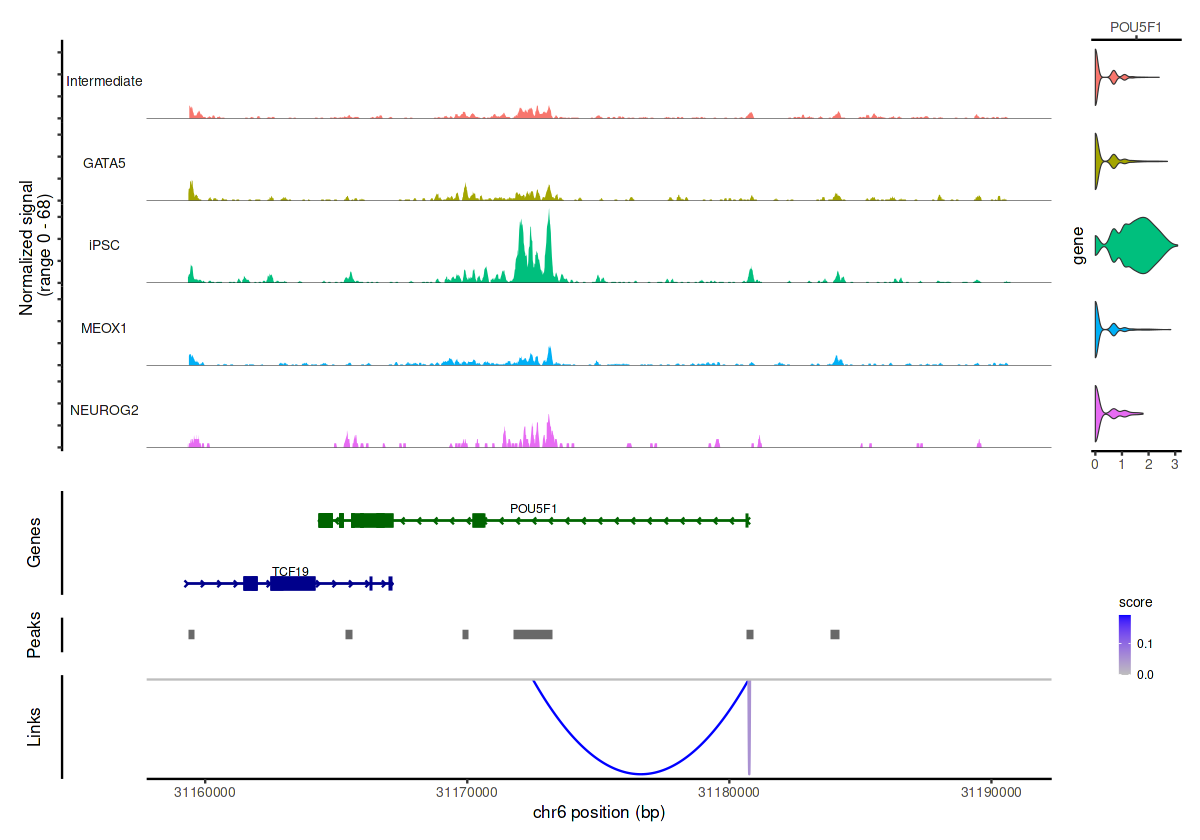

In [50]:
p4 <- CoveragePlot(
  object = seurat,
  region = "POU5F1",
  features = "POU5F1",
  expression.assay = "SCT",
  extend.upstream = 5000,
  extend.downstream = 10000
)
#patchwork::wrap_plots(p4, ncol = 1)
p4 & theme(text = element_text(size = 10))


Warning message:
"Removed 86 rows containing missing values (`geom_segment()`)."


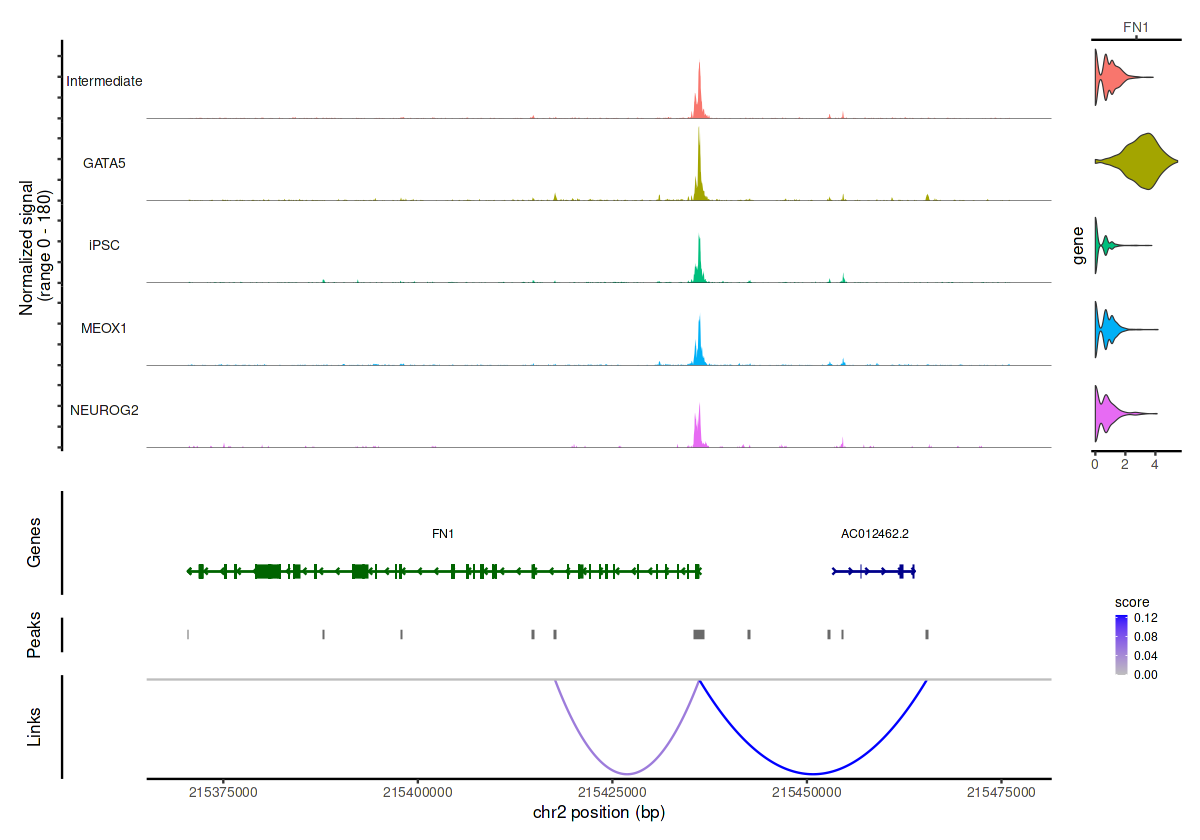

In [51]:
p5 <- CoveragePlot(
  object = seurat,
  region = "FN1",
  features = "FN1",
  expression.assay = "SCT",
  extend.upstream = -10000,
  extend.downstream = 40000
)
#patchwork::wrap_plots(p5, ncol = 1)
p5 & theme(text = element_text(size = 10))

In [52]:
saveRDS(object = seurat, file = "/home/jupyter-ayang/notebooks/cat-atac_pipeline/cond9/secondary/output/notebooks/signac/cond9.rds")

In [53]:
DefaultAssay(seurat) <- "peaks"

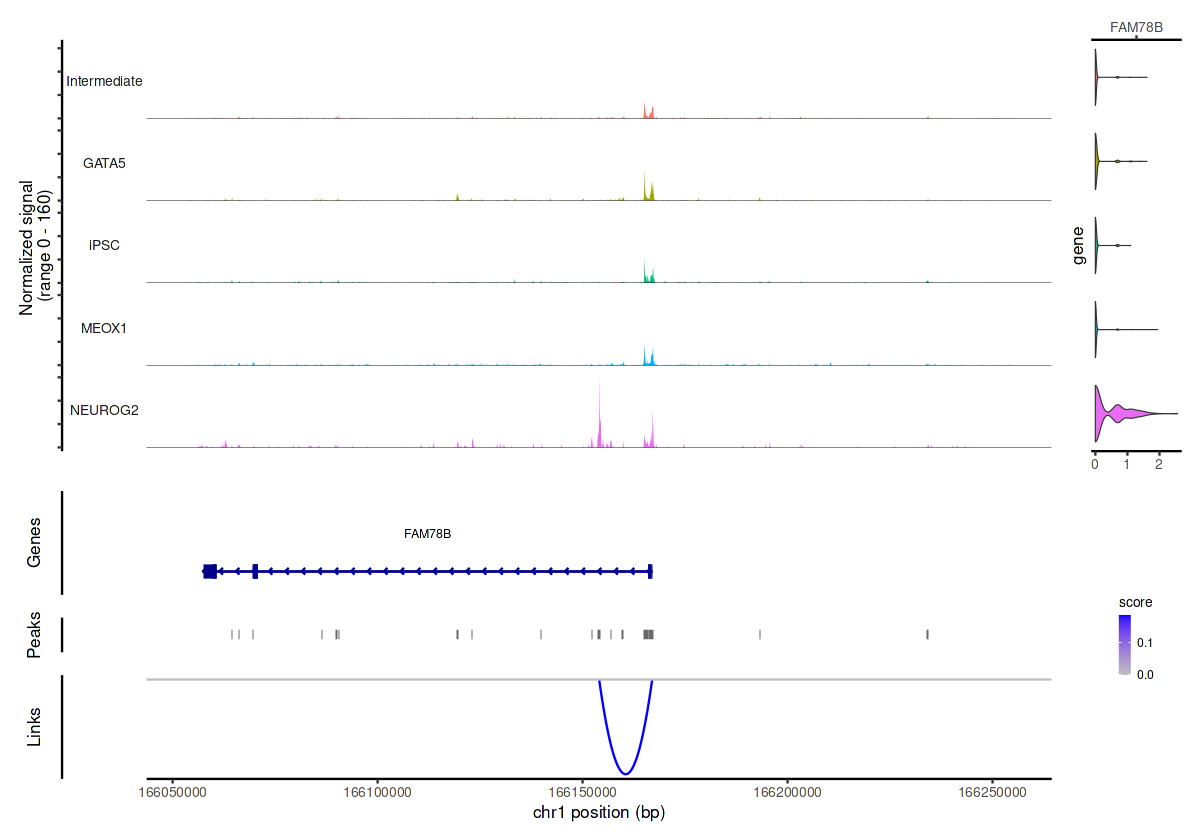

In [54]:
p6 <- CoveragePlot(
  object = seurat,
  region = "chr1-166153708-166154398",
  features = "FAM78B",
  expression.assay = "SCT",
  extend.upstream = 100000,
  extend.downstream = 100000,
  links = TRUE
)
p6 & theme(text = element_text(size = 10))

Warning message:
"Removed 17 rows containing missing values (`geom_segment()`)."


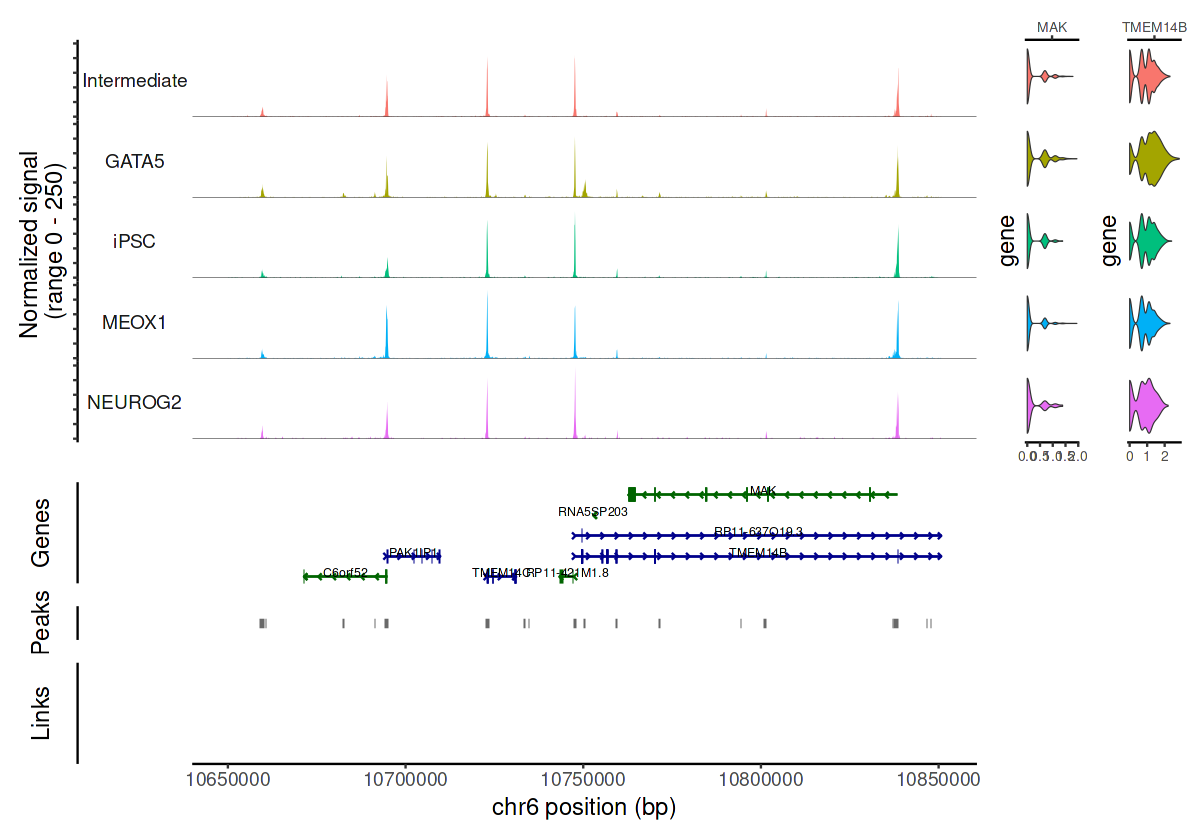

In [55]:
p7 <- CoveragePlot(
  object = seurat,
  region = "chr6-10749999-10750752",
  features = c("MAK", "TMEM14B"),
  expression.assay = "SCT",
  extend.upstream = 100000,
  extend.downstream = 100000,
  links = TRUE
)
p7 & theme(text = element_text(size = 14))